# Preliminary set-up

Kaggle Dataset: https://www.kaggle.com/c/facial-keypoints-detector


In [0]:
anger=0
disgust=1
fear=2
happy=3
sad=4
surprise=5
neutral=6

## Interact with Google Collab

In [78]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.

# PyDrive simplifies many common Google Drive API tasks.
!pip install -U -q PyDrive
# -q means quiet

# provide the ability to authenticate to Google APIs using various methods.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Be able to work within google folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import  libraries & Prep Data

In [0]:
import itertools
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras import optimizers
from keras import Sequential
from keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import VGG16, VGG19
from keras.layers import Flatten, Dropout, Reshape
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import model_from_json


In [0]:
# Read in the files from Google Drive
test_df = pd.read_csv('drive/My Drive/Colab Notebooks/test.csv')
train_df = pd.read_csv('drive/My Drive/Colab Notebooks/train.csv')

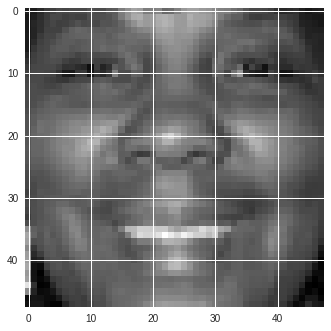

In [81]:
# View an image
i = 2568
list_pixels = np.array([int(string) for string in train_df.iloc[i,1].split(' ')])
pixeled_image = list_pixels.reshape(48,48)
plt.imshow(pixeled_image, cmap='gray');  

# Base Model (Dense)

## Prep Data for Model

In [0]:
# Split train data into x,y values for train and validation
x_train = []
for i in range(len(train_df)):
  list_pixels = [int(string) for string in train_df.iloc[i,1].split(' ')]
  x_train.append(list_pixels)
x = np.array(x_train)
y = train_df.iloc[:,0]


In [0]:
# Categorize y to for compatiblity with softmax activation
from keras.utils import to_categorical
y_cat = to_categorical(np.array(y))

In [0]:
# Train_test_split training data into training and testing sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y_cat, random_state = 123, test_size = 0.10)


In [0]:
# Train_test_split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [86]:
# Check Shape
print(x_train.shape) # (3008, 2304)
print(x_test.shape) # (418, 2304)
print(y_train.shape) # (3008, 7)
print(y_test.shape) # (418, 7)
print(x_val.shape) # (752,2304)
print(y_val.shape) # (752, 7)

(3008, 2304)
(418, 2304)
(3008, 7)
(418, 7)
(752, 2304)
(752, 7)


## Build and Run Model

Run Dense Model, Epoch = 50

In [0]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model = models.Sequential()

In [0]:
# Add layers to model. 3 relus and one softmax
model.add(layers.Dense(256, activation='relu', input_shape=(2304,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7, activation='softmax')) # need # of nodes to match # of classes

In [0]:
# look at categorical loss and use accuracy as metric with stochastic gradient descent as optimizer
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [90]:
# Like cross-validation
# Fit data to training set; use the validation set as a testing set for the batches 
history = model.fit(x_train,
                    y_train,
                    epochs=15,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Train on 3008 samples, validate on 752 samples
Epoch 1/15
3008/3008 [==============================] - 20s 7ms/step - loss: 14.4236 - acc: 0.1034 - val_loss: 14.7035 - val_acc: 0.0878
Epoch 2/15
3008/3008 [==============================] - 0s 111us/step - loss: 14.4838 - acc: 0.1014 - val_loss: 14.7035 - val_acc: 0.0878
Epoch 3/15
3008/3008 [==============================] - 0s 107us/step - loss: 14.4838 - acc: 0.1014 - val_loss: 14.7035 - val_acc: 0.0878
Epoch 4/15
3008/3008 [==============================] - 0s 109us/step - loss: 14.4838 - acc: 0.1014 - val_loss: 14.7035 - val_acc: 0.0878
Epoch 5/15
3008/3008 [==============================] - 0s 110us/step - loss: 14.4838 - acc: 0.1014 - val_loss: 14.7035 - val_acc: 0.0878
Epoch 6/15
3008/3008 [==============================] - 0s 107us/step - loss: 14.4838 - acc: 0.1014 - val_loss: 14.7035 - val_acc: 0.0878
Epoch 7/15
3008/3008 [==============================] - 0s 108us/step - loss: 14.4838 - acc: 0.1014 - val_loss: 14.7035 - val_

***`We will not test or visualize these results because this is our base case (the accuracy is bad).`***


# CNN trial 1

tanh , softmax, cnn, batch size 100, epoch 100, no early callback, 4 layers, non standarized

## Prep Data for Model

In [0]:
# Reshape 1D array to 2D matrix for Conv2D

x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers
  list_pixels = [int(string) for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [0]:
# Categorize y for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [93]:
print(x.shape) # (4178, 48, 48)
y.shape # (4178, 7)

(4178, 48, 48)


(4178, 7)

In [0]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, random_state = 123, test_size = 0.10)

In [0]:
# Train_test_split training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [96]:
# Check shapes to ensure it's right
print(x_train.shape) # (3008, 48, 48)
print(x_test.shape) # (418, 48, 48)
print(y_train.shape) # (3008, 7)
print(y_test.shape) # (418, 7)
print(x_val.shape) # (752, 7)
print(y_val.shape)

(3008, 48, 48)
(418, 48, 48)
(3008, 7)
(418, 7)
(752, 48, 48)
(752, 7)


In [0]:
# Reshape the data to be  (2924, 48, 48, 1) and (1254, 48, 48, 1) for x_train and x_val
# respectively. need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [98]:
print(x_train_reshaped.shape) #(3008, 48, 48, 1)
print(x_val_reshaped.shape) #(752, 48, 48, 1)
print(x_test_reshaped.shape) #(418, 48, 48, 1)

(3008, 48, 48, 1)
(752, 48, 48, 1)
(418, 48, 48, 1)


## Build and Run Model

In [0]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_cnn = models.Sequential()

In [0]:
model_cnn.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2),
                 activation='tanh',
                   input_shape=(48,48,1))) # kernel size = filter window size. 32 = number of output channels
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_cnn.add(Conv2D(64, (5, 5), activation='tanh'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='tanh'))
model_cnn.add(layers.Dense(7, activation='softmax')) # 7 classifications 

In [0]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [102]:
history_cnn = model_cnn.fit(x_train_reshaped,
                    y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(x_val_reshaped, y_val))

# Epoch 99/100: 2924/2924 [==============================] - 0s 120us/step - 
# loss: 0.6863 - acc: 0.7589 - val_loss: 0.9786 - val_acc: 0.6316


Train on 3008 samples, validate on 752 samples
Epoch 1/100
3008/3008 [==============================] - 21s 7ms/step - loss: 1.9142 - acc: 0.2736 - val_loss: 2.0750 - val_acc: 0.0984
Epoch 2/100
3008/3008 [==============================] - 0s 154us/step - loss: 1.8695 - acc: 0.2779 - val_loss: 1.9187 - val_acc: 0.1888
Epoch 3/100
3008/3008 [==============================] - 0s 159us/step - loss: 1.8502 - acc: 0.2839 - val_loss: 1.8805 - val_acc: 0.2540
Epoch 4/100
3008/3008 [==============================] - 0s 157us/step - loss: 1.8463 - acc: 0.2999 - val_loss: 1.8814 - val_acc: 0.3005
Epoch 5/100
3008/3008 [==============================] - 0s 158us/step - loss: 1.8570 - acc: 0.2886 - val_loss: 2.0702 - val_acc: 0.1888
Epoch 6/100
3008/3008 [==============================] - 0s 156us/step - loss: 1.8515 - acc: 0.2989 - val_loss: 1.8190 - val_acc: 0.3085
Epoch 7/100
3008/3008 [==============================] - 0s 158us/step - loss: 1.8160 - acc: 0.3045 - val_loss: 1.8091 - val_acc: 0.

## Plot Errors and Accuracy (Training & Validation)

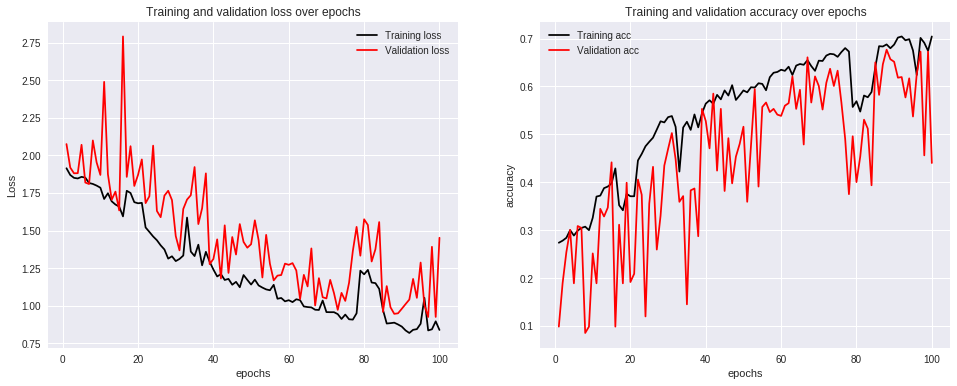

In [103]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss = hist_dense['loss'] 
val_loss = hist_dense['val_loss']
acc= hist_dense['acc']
val_acc = hist_dense['val_acc']

epochs = range(1, len(loss) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss, 'k', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## Test Model

In [104]:
#Results in form of [loss, accuracy]
results_train_cnn = model_cnn.evaluate(x_train_reshaped, y_train)
results_train_cnn

3008/3008 [==============================] - 1s 222us/step


[1.421148363580095, 0.44680851063829785]

In [105]:
#Results in form [loss, accuracy]
results_test_cnn = model_cnn.evaluate(x_test_reshaped, y_test)
results_test_cnn

418/418 [==============================] - 0s 240us/step


[1.426944648249868, 0.43779904306220097]

In [0]:
y_hat = model_cnn.predict(x_test_reshaped)

## Mectrics

### Plot Errors and Accuracy (Training & Validation)

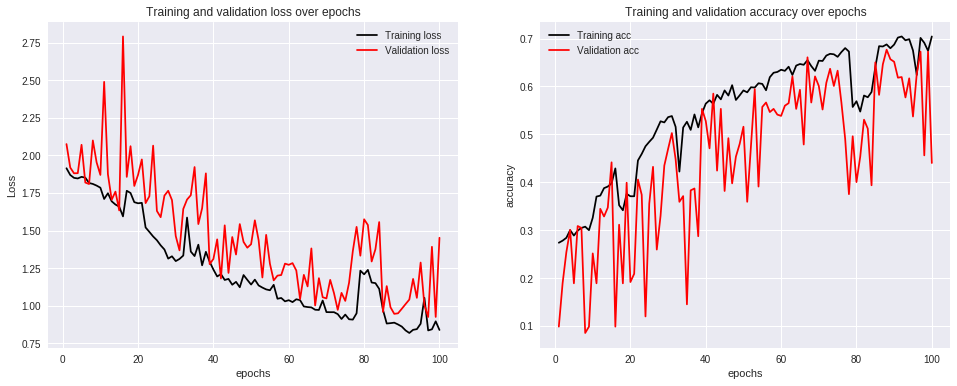

In [107]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss = hist_dense['loss'] 
val_loss = hist_dense['val_loss']
acc= hist_dense['acc']
val_acc = hist_dense['val_acc']

epochs = range(1, len(loss) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss, 'k', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Other Metrics

In [108]:
# Get F1 score, recall and precision

def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  y_pred = np.array(y_hate)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

('F1: 0.4480278428859911',
 'precision: 0.5821990140814959',
 'recall: 0.43779904306220097')

In [109]:
# Can get f1, recall, and precision for each of the categories
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.74      0.47      0.57        43
           1       0.73      0.88      0.80        42
           2       0.74      0.81      0.77        53
           3       0.94      0.98      0.96        62
           4       0.76      0.80      0.78        46
           5       0.96      0.88      0.92        50
           6       0.92      0.92      0.92       122

   micro avg       0.85      0.85      0.85       418
   macro avg       0.83      0.82      0.82       418
weighted avg       0.85      0.85      0.84       418
 samples avg       0.85      0.85      0.85       418



### Confusion Matrix

In [0]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


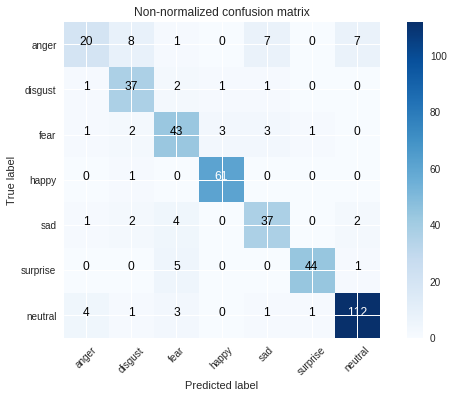

In [111]:
# Get Confusion matrix
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

#CNN trial 2

standarized, 4 layers, cnn, tanh, softmax, batch size 10, epoch 30, early callback

## Prep Data for Model

In [0]:
# Reshape 1D array to 2D matrix for Conv2D

x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standarize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [0]:
# Categorize y for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [114]:
print(x.shape) # (4178, 48, 48)
y.shape # (4178, 7)

(4178, 48, 48)


(4178, 7)

In [0]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, random_state = 123, test_size = 0.10)


In [0]:
# Create train_test_split for validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [117]:
# Check shapes to ensure it's right
print(x_train.shape) # (3008, 48, 48)
print(x_test.shape) # (418, 48, 48)
print(y_train.shape) # (3008, 7)
print(y_test.shape) # (418, 7)
print(x_val.shape) # (752, 7)
print(y_val.shape)

(3008, 48, 48)
(418, 48, 48)
(3008, 7)
(418, 7)
(752, 48, 48)
(752, 7)


In [0]:
# Reshape the data to be  (2924, 48, 48, 1) and (1254, 48, 48, 1) for x_train and x_val
# respectively. need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [119]:
print(x_train_reshaped.shape) #(3008, 48, 48, 1)
print(x_val_reshaped.shape) #(752, 48, 48, 1)
print(x_test_reshaped.shape) #(418, 48, 48, 1)

(3008, 48, 48, 1)
(752, 48, 48, 1)
(418, 48, 48, 1)


## Build and Run Model

In [0]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_cnn = models.Sequential()

In [0]:
model_cnn.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2),
                 activation='tanh',
                   input_shape=(48,48,1))) # kernel size = filter window size. 32 = number of output channels

model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_cnn.add(Conv2D(64, (5, 5), activation='tanh'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='tanh'))
model_cnn.add(layers.Dense(7, activation='softmax')) # 7 classifications 

In [0]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=3,
                              verbose=0, mode='auto')

In [124]:
history_cnn = model_cnn.fit(x_train_reshaped,
                    y_train,
                    epochs=35,
                    batch_size=10,
                    validation_data=(x_val_reshaped, y_val), callbacks= [earlystop])

# Epoch 29/35
# 3008/3008 [==============================] - 2s 604us/step - loss: 0.3310 - acc: 0.8916 - val_loss: 0.6368 - val_acc: 0.7859


Train on 3008 samples, validate on 752 samples
Epoch 1/35
3008/3008 [==============================] - 24s 8ms/step - loss: 1.8413 - acc: 0.2965 - val_loss: 1.7845 - val_acc: 0.3497
Epoch 2/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.7537 - acc: 0.3587 - val_loss: 1.6854 - val_acc: 0.4415
Epoch 3/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.5912 - acc: 0.4408 - val_loss: 1.4687 - val_acc: 0.4761
Epoch 4/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.4149 - acc: 0.5043 - val_loss: 1.3079 - val_acc: 0.5585
Epoch 5/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.2767 - acc: 0.5642 - val_loss: 1.2162 - val_acc: 0.5652
Epoch 6/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.1727 - acc: 0.5977 - val_loss: 1.1157 - val_acc: 0.6157
Epoch 7/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.0779 - acc: 0.6260 - val_loss: 1.0267 - val_acc: 0.6543
Epoch 8/35
300

## Test Model

In [125]:
#Results in form [loss, accuracy]
results_train_cnn = model_cnn.evaluate(x_train_reshaped, y_train)
results_train_cnn

3008/3008 [==============================] - 1s 203us/step


[0.31655528951198497, 0.897938829787234]

In [126]:
#Results of train with CNN
results_train_cnn = model_cnn.evaluate(x_test_reshaped, y_test)
results_train_cnn

418/418 [==============================] - 0s 240us/step


[0.6795123946010782, 0.7870813397129187]

In [0]:
y_hat = model_cnn.predict(x_test_reshaped)

## Metrics

### Plot Errors and Accuracy (Training & Validation)

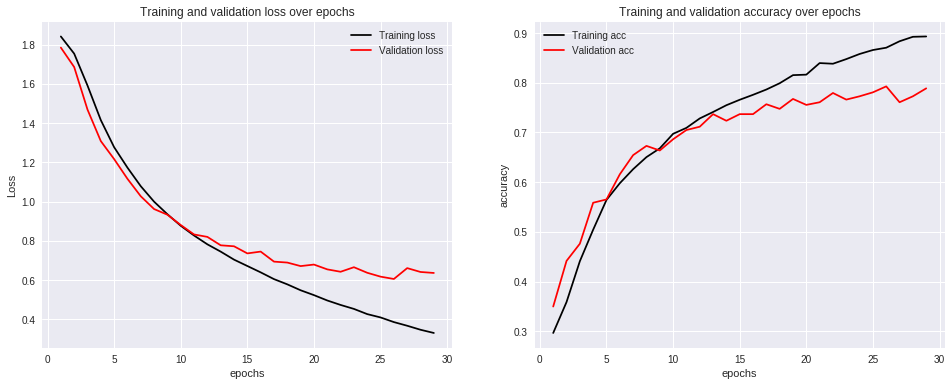

In [128]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss = hist_dense['loss'] 
val_loss = hist_dense['val_loss']
acc= hist_dense['acc']
val_acc = hist_dense['val_acc']

epochs = range(1, len(loss) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss, 'k', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Other Metrics

In [129]:
# Get F1 score, recall and precision

def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  global y_pred
  y_pred = np.array(y_hate)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

('F1: 0.7835313281777126',
 'precision: 0.7905045108758032',
 'recall: 0.7870813397129187')

In [130]:
# Can get f1, recall, and precision for each of the categories
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.62      0.72      0.67        43
           1       0.85      0.83      0.84        42
           2       0.82      0.60      0.70        53
           3       0.95      0.94      0.94        62
           4       0.58      0.48      0.52        46
           5       0.91      0.80      0.85        50
           6       0.77      0.91      0.83       122

   micro avg       0.79      0.79      0.79       418
   macro avg       0.79      0.75      0.77       418
weighted avg       0.79      0.79      0.78       418
 samples avg       0.79      0.79      0.79       418



### Confusion Matrix

In [0]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


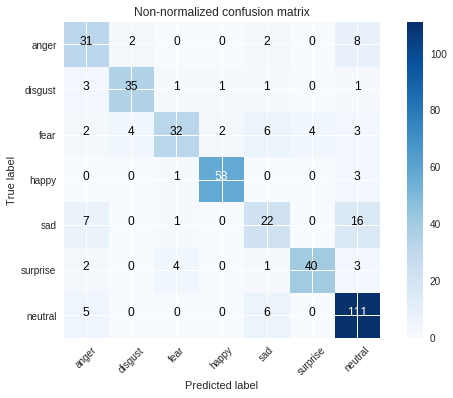

In [132]:
# Get Confusion matrix
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

# CNN trial 3

increasing layer amount (1 extra)

## Prep Data for Model

In [0]:
# Reshape 1D array to 2D matrix for Conv2D
x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standardize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)
  
x = np.array(x_train)
y = train_df.iloc[:,0]

In [0]:
# Categorize y to y category for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [135]:
print(x.shape) # (4178, 48, 48)
y.shape # (4178, 7)

(4178, 48, 48)


(4178, 7)

In [0]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, \
                                          random_state = 123, test_size = 0.10)



In [0]:
# Create train_test_split for validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [138]:
# Check shapes to ensure it's right
print(x_train.shape) # (3008, 48, 48)
print(x_test.shape) # (418, 48, 48)
print(y_train.shape) # (3008, 7)
print(y_test.shape) # (418, 7)
print(x_val.shape) # (752, 7)
print(y_val.shape)

(3008, 48, 48)
(418, 48, 48)
(3008, 7)
(418, 7)
(752, 48, 48)
(752, 7)


In [0]:
# Reshape the data to be  (2924, 48, 48, 1) and (1254, 48, 48, 1) for x_train and x_val
# respectively. need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)

In [140]:
print(x_train_reshaped.shape) #(3008, 48, 48, 1)
print(x_val_reshaped.shape) #(752, 48, 48, 1)
print(x_test_reshaped.shape) #(418, 48, 48, 1)

(3008, 48, 48, 1)
(752, 48, 48, 1)
(418, 48, 48, 1)


## Build and Run Model

adding more layers

In [0]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_cnn = models.Sequential()

In [0]:
model_cnn.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2),
                 activation='tanh',
                   input_shape=(48,48,1)))
# kernel size = filter window size
# 32 = number of output channels
# output is 45x45
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_cnn.add(Conv2D(64, (5, 5), activation='tanh'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(128, (3, 3), activation='tanh'))
model_cnn.add(MaxPooling2D(pool_size=(1, 1)))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='tanh'))
model_cnn.add(layers.Dense(7, activation='softmax')) # 7 classifications 

In [0]:
model_cnn.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.005,
                              patience=2,
                              verbose=0, mode='auto')

In [145]:
history_cnn = model_cnn.fit(x_train_reshaped,
                    y_train,
                    epochs=35,
                    batch_size=10,
                    validation_data=(x_val_reshaped, y_val), callbacks= [earlystop])

#Epoch 22/35
# 3008/3008 [==============================] - 2s 771us/step - loss: 0.3904 - acc: 0.8677 - val_loss: 0.6133 - val_acc: 0.7912


Train on 3008 samples, validate on 752 samples
Epoch 1/35
3008/3008 [==============================] - 24s 8ms/step - loss: 1.8496 - acc: 0.2846 - val_loss: 1.8221 - val_acc: 0.3005
Epoch 2/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.7936 - acc: 0.3291 - val_loss: 1.7166 - val_acc: 0.3949
Epoch 3/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.6220 - acc: 0.4302 - val_loss: 1.5181 - val_acc: 0.4668
Epoch 4/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.4218 - acc: 0.5113 - val_loss: 1.3756 - val_acc: 0.5146
Epoch 5/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.2947 - acc: 0.5502 - val_loss: 1.2325 - val_acc: 0.5851
Epoch 6/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.1838 - acc: 0.5868 - val_loss: 1.1451 - val_acc: 0.6037
Epoch 7/35
3008/3008 [==============================] - 3s 1ms/step - loss: 1.0827 - acc: 0.6190 - val_loss: 1.0608 - val_acc: 0.6144
Epoch 8/35
300

## Plot Errors and Accuracy (Training & Validation)




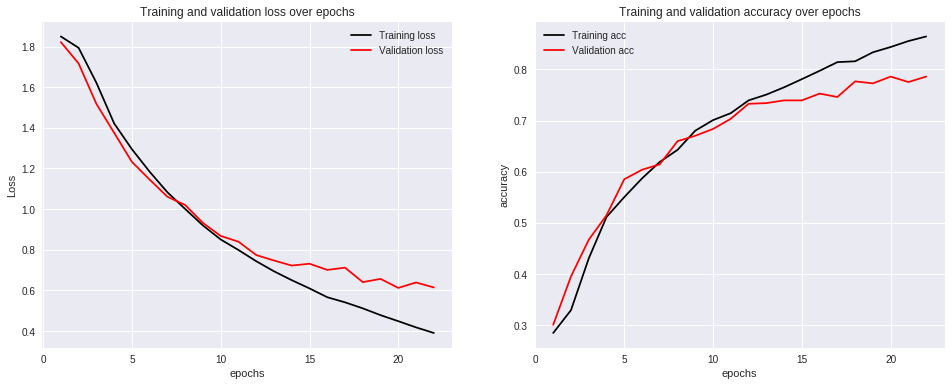

In [146]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss = hist_dense['loss'] 
val_loss = hist_dense['val_loss']
acc= hist_dense['acc']
val_acc = hist_dense['val_acc']

epochs = range(1, len(loss) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss, 'k', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

## Test Model

In [147]:
# Evaluate for train set
results_train_cnn = model_cnn.evaluate(x_train_reshaped, y_train)
results_train_cnn

3008/3008 [==============================] - 1s 223us/step


[0.3297176194634843, 0.894281914893617]

In [148]:
# Evaluate for test set
results_train_cnn = model_cnn.evaluate(x_train_reshaped, y_train)
results_train_cnn

3008/3008 [==============================] - 1s 220us/step


[0.3297176194634843, 0.894281914893617]

In [0]:
y_hat = model_cnn.predict(x_test_reshaped)

## Metrics

### Plot Errors and Accuracy (Training & Validation)

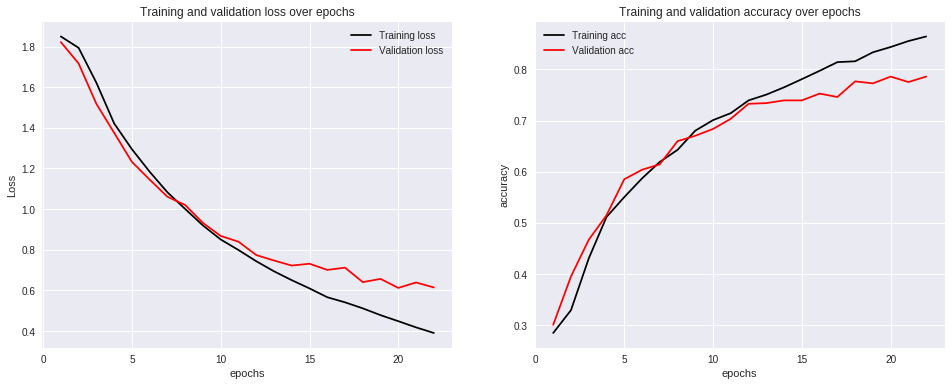

In [150]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss = hist_dense['loss'] 
val_loss = hist_dense['val_loss']
acc= hist_dense['acc']
val_acc = hist_dense['val_acc']

epochs = range(1, len(loss) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss, 'k', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Other metrics

In [151]:
# Get F1 score, recall and precision

def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  global y_pred
  y_pred = np.array(y_hate)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

('F1: 0.7792510150917745',
 'precision: 0.779386079670032',
 'recall: 0.784688995215311')

In [152]:
# Can get f1, recall, and precision for each of the categories
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.63      0.60      0.62        43
           1       0.79      0.79      0.79        42
           2       0.71      0.66      0.69        53
           3       0.95      0.94      0.94        62
           4       0.63      0.48      0.54        46
           5       0.85      0.82      0.84        50
           6       0.80      0.93      0.86       122

   micro avg       0.78      0.78      0.78       418
   macro avg       0.77      0.74      0.75       418
weighted avg       0.78      0.78      0.78       418
 samples avg       0.78      0.78      0.78       418



### Confusion Matrix

In [0]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


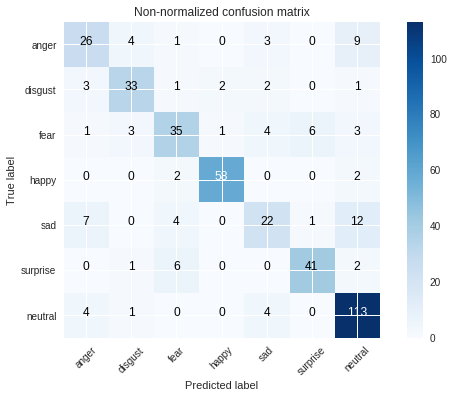

In [154]:
# Get Confusion matrix
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

# Transfer Learning (VGG16)

## Prep Data for Model

In [0]:
# Reshape 1D array to 2D matrix for Conv2D

x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standarize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [0]:
# Categorize y to y category for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [157]:
print(x.shape) # (4178, 48, 48)
y.shape # (4178, 7)

(4178, 48, 48)


(4178, 7)

In [0]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, \
                                          random_state = 123, test_size = 0.10)



In [0]:
# Create train_test_split for validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [160]:
# Check shapes to ensure it's right
print(x_train.shape) # (3008, 48, 48)
print(x_test.shape) # (418, 48, 48)
print(y_train.shape) # (3008, 7)
print(y_test.shape) # (418, 7)
print(x_val.shape) # (752, 7)
print(y_val.shape)

(3008, 48, 48)
(418, 48, 48)
(3008, 7)
(418, 7)
(752, 48, 48)
(752, 7)


In [0]:
# Reshape the data to be  (2924, 48, 48, 1) and (1254, 48, 48, 1) for x_train and x_val
# respectively. need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)


In [0]:
# Need to repeat our 48x48x1 to 3 dimensions, because transfer learning models take RGB format
x_train_reshaped = np.repeat(x_train_reshaped, 3, axis=3)
x_val_reshaped = np.repeat(x_val_reshaped, 3, axis=3)
x_test_reshaped = np.repeat(x_test_reshaped, 3, axis=3)

In [163]:
print(x_train_reshaped.shape) #(3008, 48, 48, 3)
print(x_val_reshaped.shape) #(752, 48, 48, 3)
print(x_test_reshaped.shape) #(418, 48, 48, 3)

(3008, 48, 48, 3)
(752, 48, 48, 3)
(418, 48, 48, 3)


In [164]:
y_test.shape

(418, 7)

## Build and Run Model

In [165]:
# Set seed to get same results
np.random.seed(123)
cnn_base = VGG16(include_top= False, weights='imagenet', input_shape = (48,48,3))

58892288/58889256 [==============================] - 5s 0us/step


In [0]:
# Define model as Sequential class
model_cnn = models.Sequential()

In [0]:
model_cnn.add(cnn_base)
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='tanh'))
model_cnn.add(layers.Dense(64, activation='tanh'))
model_cnn.add(layers.Dense(7, activation='softmax')) # 7 classifications 

In [0]:
model_cnn.compile(loss='categorical_crossentropy',

                  optimizer="sgd",
              metrics=['acc'])

In [0]:
# or if we want to set the first 19 layers of the network to be non-trainable
for layer in model_cnn.layers[:16]:
   layer.trainable=False
for layer in model_cnn.layers[16:]:
   layer.trainable=True

    
# Note: tried running the freeze before compiling model. This yielded low accuracy scores
# Decided to compile model first, then freeze first 16 years (the VGG16 layers)

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.005,
                              patience=2,
                              verbose=0, mode='auto')

In [171]:
history_cnn = model_cnn.fit(x_train_reshaped,
                    y_train,
                    epochs=15,
                    batch_size=10,
                    validation_data=(x_val_reshaped, y_val), callbacks= [earlystop])

# Epoch 8/100
# 3008/3008 [==============================] - 19s 6ms/step - loss: 0.2294 - acc: 0.9209 - val_loss: 0.4672 - val_acc: 0.8391

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 3008 samples, validate on 752 samples
Epoch 1/15
3008/3008 [==============================] - 42s 14ms/step - loss: 1.4469 - acc: 0.4658 - val_loss: 1.0072 - val_acc: 0.6396
Epoch 2/15
3008/3008 [==============================] - 21s 7ms/step - loss: 0.8808 - acc: 0.6818 - val_loss: 0.7828 - val_acc: 0.7327
Epoch 3/15
3008/3008 [==============================] - 21s 7ms/step - loss: 0.6636 - acc: 0.7656 - val_loss: 0.5688 - val_acc: 0.8005
Epoch 4/15
3008/3008 [==============================] - 21s 7ms/step - loss: 0.5239 - acc: 0.8118 - val_loss: 0.6025 - val_acc: 0.7886
Epoch 5/15
3008/3008 [==============================] - 21s 7ms/step - loss: 0.4080 - acc: 0.8574 - val_loss: 0.4594 - val_acc: 0.8298
Epoch 6/15
3008/3008 [==============================] - 21s 7ms/step - loss: 0.3474 - acc: 0.8723 - val_loss: 0.4613 - val_acc: 0.8324
Epoch 7/15
3008/3008 [==============================] - 21s 7ms/step - loss: 0.2658 - acc: 0.9039 - val_loss: 0.4322 - val_acc: 0.8511
Epoch 8

## Test Model

In [172]:
# Evaluate test data
results_train_cnn = model_cnn.evaluate(x_test_reshaped, y_test)
results_train_cnn

418/418 [==============================] - 0s 977us/step


[0.43666628031639393, 0.8779904306220095]

In [0]:
# predict
y_hat = model_cnn.predict(x_test_reshaped)

## Metrics

### Plot Errors and Accuracy (Training & Validation)

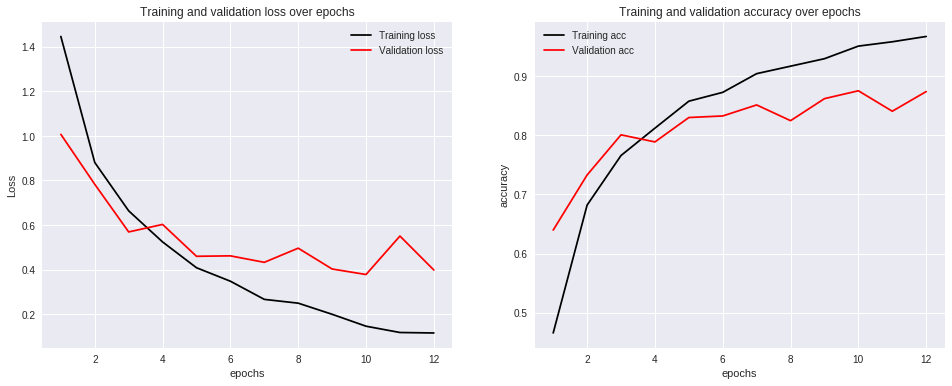

In [174]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss = hist_dense['loss'] 
val_loss = hist_dense['val_loss']
acc= hist_dense['acc']
val_acc = hist_dense['val_acc']

epochs = range(1, len(loss) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss, 'k', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Other metrics

In [175]:
# Get F1 score, recall and precision

def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  global y_pred
  y_pred = np.array(y_hate)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

('F1: 0.8781629335378284',
 'precision: 0.8868152847504267',
 'recall: 0.8779904306220095')

In [176]:
# Can get f1, recall, and precision for each of the categories
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.66      0.91      0.76        43
           1       0.87      0.93      0.90        42
           2       0.86      0.68      0.76        53
           3       0.98      0.95      0.97        62
           4       0.87      0.74      0.80        46
           5       0.87      0.94      0.90        50
           6       0.95      0.93      0.94       122

   micro avg       0.88      0.88      0.88       418
   macro avg       0.87      0.87      0.86       418
weighted avg       0.89      0.88      0.88       418
 samples avg       0.88      0.88      0.88       418



### Confusion Matrix

In [0]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


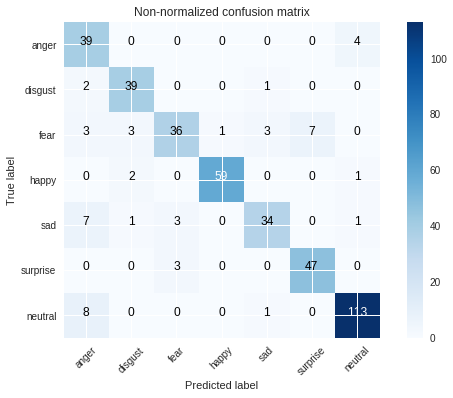

In [178]:
# Get Confusion matrix
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

# Transfer Learning (VGG19)

## Prep Data for Model

In [0]:
# Reshape 1D array to 2D matrix for Conv2D

x_train = []
for i in range(len(train_df)):
  # convert string of pixels to list of integers and standarize data
  list_pixels = [int(string)/255 for string in train_df.iloc[i,1].split(' ')]
  # reshape 1D to 2D matrix
  pixeled_image = np.array(list_pixels).reshape(48,48)
  x_train.append(pixeled_image)

x = np.array(x_train)
y = train_df.iloc[:,0]

In [180]:
y.value_counts() # Class imbalance

6    1202
3     758
5     459
1     457
4     441
0     437
2     424
Name: Emotion, dtype: int64

In [0]:
# Categorize y for compatiblity with softmax activation
from keras.utils import to_categorical
y = to_categorical(np.array(y))

In [182]:
print(x.shape) # (4178, 48, 48)
y.shape # (4178, 7)

(4178, 48, 48)


(4178, 7)

In [0]:
# Train_test_split training data into training and test sets
x_train1, x_test, y_train1, y_test =  train_test_split(x, y, \
                                          random_state = 123, test_size = 0.10)



In [0]:
# Create train_test_split for validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, random_state = 123, test_size = 0.20)

In [185]:
# Check shapes to ensure it's right
print(x_train.shape) # (3008, 48, 48)
print(x_test.shape) # (418, 48, 48)
print(y_train.shape) # (3008, 7)
print(y_test.shape) # (418, 7)
print(x_val.shape) # (752, 7)
print(y_val.shape)

(3008, 48, 48)
(418, 48, 48)
(3008, 7)
(418, 7)
(752, 48, 48)
(752, 7)


In [0]:
# Reshape the data to be  (2924, 48, 48, 1) and (1254, 48, 48, 1) for x_train and x_val
# respectively. need to do this because input_shape in model_cnn.add needs a 2D image with 
# depth specified as 1
x_train_reshaped = np.expand_dims(x_train, axis = 3)
x_val_reshaped = np.expand_dims(x_val, axis = 3)
x_test_reshaped = np.expand_dims(x_test, axis = 3)


In [0]:
# Need to repeat our 48x48x1 to 3 dimensions, because transfer learning models take RGB format
x_train_reshaped = np.repeat(x_train_reshaped, 3, axis=3)
x_val_reshaped = np.repeat(x_val_reshaped, 3, axis=3)
x_test_reshaped = np.repeat(x_test_reshaped, 3, axis=3)

In [188]:
print(x_train_reshaped.shape) #(3008, 48, 48, 3)
print(x_val_reshaped.shape) #(752, 48, 48, 3)
print(x_test_reshaped.shape) #(418, 48, 48, 3)

(3008, 48, 48, 3)
(752, 48, 48, 3)
(418, 48, 48, 3)


In [189]:
y_test.shape

(418, 7)

## Build and Run Model

In [0]:
# Set seed to get same results
np.random.seed(123)
# cnn_base = VGG16(include_top= False, weights='imagenet', input_shape = (48,48,3))
cnn_base = VGG19(include_top= False, weights='imagenet', input_shape = (48,48,3))
# cnn_base121 = densenet.DenseNet121(include_top=False, weights='imagenet', input_shape = (48,48,3))
# cnn_base169 = densenet.DenseNet169(include_top=False, weights='imagenet', input_shape = (48,48,3))
# cnn_base201 = densenet.DenseNet201(include_top=False, weights='imagenet', input_shape = (48,48,3))


In [0]:
# Define model as Sequential class
model_cnn = models.Sequential()

In [0]:
model_cnn.add(cnn_base)

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(128, activation='tanh'))
model_cnn.add(layers.Dense(64, activation='tanh'))
model_cnn.add(layers.Dense(7, activation='softmax')) # 7 classifications 

In [0]:
model_cnn.compile(loss='categorical_crossentropy',

                  optimizer="sgd",
              metrics=['acc'])

In [0]:
# or if we want to set the first 19 layers of the network to be non-trainable
for layer in model_cnn.layers[:16]:
   layer.trainable=False
for layer in model_cnn.layers[16:]:
   layer.trainable=True

    
# Note: tried running the freeze before compiling model. This yielded low accuracy scores
# Decided to compile model first, then freeze first 16 years (the VGG16 layers)

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.005,
                              patience=2,
                              verbose=0, mode='auto')

In [196]:
history_cnn = model_cnn.fit(x_train_reshaped,
                    y_train,
                    epochs=15,
                    batch_size=10,
                    validation_data=(x_val_reshaped, y_val), callbacks= [earlystop])

# Epoch 8/100
# 3008/3008 [==============================] - 19s 6ms/step - loss: 0.2294 - acc: 0.9209 - val_loss: 0.4672 - val_acc: 0.8391

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 3008 samples, validate on 752 samples
Epoch 1/15
3008/3008 [==============================] - 48s 16ms/step - loss: 1.7022 - acc: 0.3664 - val_loss: 1.3686 - val_acc: 0.5053
Epoch 2/15
3008/3008 [==============================] - 26s 9ms/step - loss: 1.0603 - acc: 0.6160 - val_loss: 1.6223 - val_acc: 0.4747
Epoch 3/15
3008/3008 [==============================] - 26s 9ms/step - loss: 0.7881 - acc: 0.7231 - val_loss: 0.6739 - val_acc: 0.7686
Epoch 4/15
3008/3008 [==============================] - 26s 9ms/step - loss: 0.6362 - acc: 0.7739 - val_loss: 0.8427 - val_acc: 0.6782
Epoch 5/15
3008/3008 [==============================] - 26s 9ms/step - loss: 0.5043 - acc: 0.8275 - val_loss: 0.5323 - val_acc: 0.8191
Epoch 6/15
3008/3008 [==============================] - 26s 9ms/step - loss: 0.4177 - acc: 0.8557 - val_loss: 0.5569 - val_acc: 0.8191
Epoch 7/15
3008/3008 [==============================] - 26s 9ms/step - loss: 0.3642 - acc: 0.8733 - val_loss: 0.4626 - val_acc: 0.8418
Epoch 8

## Test Model

In [197]:
# Evaluate test data
results_train_cnn = model_cnn.evaluate(x_test_reshaped, y_test)
results_train_cnn

418/418 [==============================] - 0s 1ms/step


[0.690538850840199, 0.784688995215311]

In [0]:
# predict
y_hat = model_cnn.predict(x_test_reshaped)

## Metrics

### Plot Errors and Accuracy

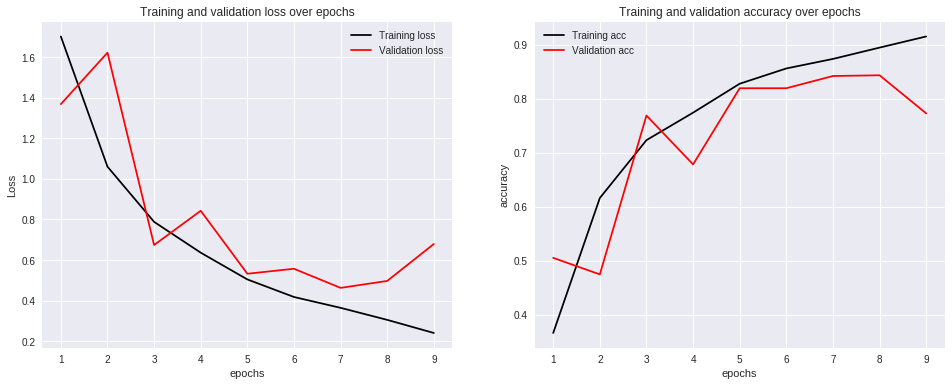

In [199]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss = hist_dense['loss'] 
val_loss = hist_dense['val_loss']
acc= hist_dense['acc']
val_acc = hist_dense['val_acc']

epochs = range(1, len(loss) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss, 'k', label= 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc, 'k', label='Training acc')
plt.plot(epochs, val_acc, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Other Metrics

In [200]:
# Get F1 score, recall and precision

def get_metrics():
  # Converted continuous probabilities to binary to get F1 score
  y_hate = []
  for i in range(0,y_hat.shape[0]):
    a = [1 if metric == y_hat[i].max() else 0 for metric in y_hat[i]]
    y_hate.append(a)
  global y_pred
  y_pred = np.array(y_hate)
  
  return 'F1: {}'.format(f1_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'precision: {}'.format(precision_score(y_true=y_test, y_pred= y_pred, average = 'weighted')), \
  'recall: {}'.format(recall_score(y_true=y_test, y_pred= y_pred, average = 'weighted')) 

get_metrics()

('F1: 0.7802456907861621',
 'precision: 0.8318036119471527',
 'recall: 0.784688995215311')

In [201]:
# Can get f1, recall, and precision for each of the categories
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

              precision    recall  f1-score   support

           0       0.92      0.28      0.43        43
           1       0.67      0.83      0.74        42
           2       0.80      0.75      0.78        53
           3       0.92      0.98      0.95        62
           4       0.48      0.87      0.62        46
           5       0.87      0.94      0.90        50
           6       0.94      0.76      0.84       122

   micro avg       0.78      0.78      0.78       418
   macro avg       0.80      0.77      0.75       418
weighted avg       0.83      0.78      0.78       418
 samples avg       0.78      0.78      0.78       418



### Confusion Matrix

In [0]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


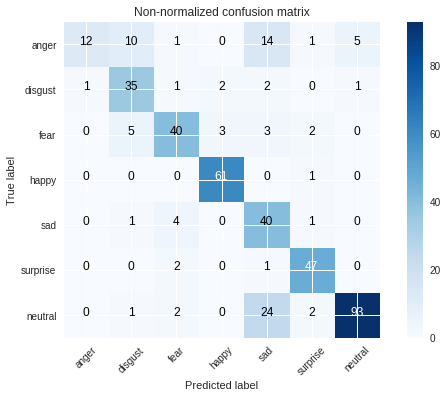

In [203]:
# Get Confusion matrix
cm_ = confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False, \
                      title='Non-normalized confusion matrix')

## Save Model for Video!

In [204]:
model_json = model_cnn.to_json()
with open("drive/My Drive/Colab Notebooks/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_cnn.save_weights("drive/My Drive/Colab Notebooks/model_weights.h5")
print("Saved model to drive")

Saved model to drive
